# Snapshots at peak intensity of
# A) mslp (contours), 10m wind (arrows), and 6hr precip (shading)
# and
# B) mslp (contours), 850 hPa wind speed (arrows), and 850 hPa spec hum (shading)
# at 2.5 km

Christoph Braun, 2023-05


for cases CTL, 4K, 4KqvCTL, Tanom

1 time step: peak intensity for each case determind by timestep with minimum pmin from cyclone tracks

2 combinations of vars (see headline)

native triangular grid

cyclone centered

### Load required libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

import xarray as xr
import numpy as np
import pandas as pd

from collections import defaultdict

from numba import njit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as pe

### Define dicts to access data

In [2]:
#####################################################
# cyclone specific data
#####################################################
# channel_Xkm_0001: control simulations
# channel_Xkm_0002: +4K, qv consistent with T
# channel_Xkm_0003: +4k, qv from control
# channel_Xkm_0004: +temperature anomaly from MPI-ESM1-2-LR far future
# channel_Xkm_0005: +tropical temperature anomaly from MPI-ESM1-2-LR far future
# channel_Xkm_0006: +polar temperature anomaly from MPI-ESM1-2-LR far future

# Note that the  2-km experiments contain outputs every 6 hrs
# Note that the 80-km experiments contain outputs every 1 hrs


expname = {
      1: 'CTL',    
      2: 'T+4K',
      3: 'T+4K_RH-',
      4: 'T+anom',
      5: 'T+TRanom',
      6: 'T+POanom'
         }

exp80 = { 
      1:'channel_80km_0001',
      2:'channel_80km_0002',
      3:'channel_80km_0003',
      4:'channel_80km_0004',
      5:'channel_80km_0005',
      6:'channel_80km_0006',
      }

exp2 = { 
      1:'channel_2km_0001',
      2:'channel_2km_0002',
      3:'channel_2km_0003',
      4:'channel_2km_0004',
      5:'channel_2km_0005',
      6:'channel_2km_0006',
      }


### Set experiments to load data for

In [3]:
experiments = [exp2[1],exp2[2],exp2[3],exp2[4]]

### Set domain parameters

In [4]:
# desired latitudinal extent of data
latmin = 20
latmax = 65

# longitudinal extent of data
lon_min=12.5
lon_ext=51
lon_max=lon_min+lon_ext

### Read in track data

In [5]:
def read_track_data(exp,track_dur,track_lon,track_lat,track_pmin):

    # path
    path_track = '/work/bb1152/Module_A/A6_CyclEx/pp_data/cyclone_tracks/'

    df_track = pd.read_csv(path_track+'Track_for_'+exp+'_6hrly_1x1latlon.csv')
    
    # extract vars of interest
    track_dur[exp]  = df_track['time']+1
    track_lon[exp]  = df_track['lon']
    track_lat[exp]  = df_track['lat']
    track_pmin[exp] = df_track['pmin']
    
    return track_dur,track_lon,track_lat,track_pmin

In [6]:
track_dur  = {}
track_lon  = {}
track_lat  = {}
track_pmin = {}

for exp in experiments:
    track_dur,track_lon,track_lat,track_pmin = read_track_data(exp,
                                                               track_dur,
                                                               track_lon,
                                                               track_lat,
                                                               track_pmin)

### Find indices and timesteps of minimum pmin

In [7]:
t_index = {}

for exp in experiments:
    t_index[exp] = track_pmin[exp].idxmin()
    #t_index[exp] = 24 # day 7
    print(t_index[exp])

27
24
27
25


In [8]:
t_plot = {}
sameday = 7.0

for exp in experiments:
    t_plot[exp] = track_dur[exp][t_index[exp]]
    #t_plot[exp] = sameday
    print(t_plot[exp])

7.75
7.0
7.75
7.25


### Determine required shift of data in longitudinal direction for centering on location of pmin

In [9]:
def get_lon_shift(cen_lon):
    
    shift = lon_min + lon_ext/2 - cen_lon

    return shift

In [10]:
shift = defaultdict(dict)

for exp in experiments:
    shift[exp] = get_lon_shift(track_lon[exp][t_index[exp]])

### Load raw simulation output

####  Helper function for loading data

In [11]:
def load_iconsimulation(expid):
    
    print('Working on loading data for', expid)
    # set path to data
    path  = '/work/bb1152/Module_A/A6_CyclEx/sim_data/production'
    # set path to grid
    gridpath = '/work/bb1152/Module_A/A6_CyclEx/input_data/'
    # set grid file
    
    # 2d datasets
    if (expid in list(exp80.values())):
        fname = path+'/'+expid+'/raw_data/icon-atm2d_ML_202101*Z.nc'
        gridfile = 'Channel_4000x9000_80000m_with_boundary.nc'
    else:
        fname = path+'/'+expid+'/icon-atm2d_ML_202101*Z.nc'
        gridfile = 'Channel_4000x9000_2500m_with_boundary.nc'
    print(fname)
    ds_2d = xr.open_mfdataset(fname).rename({'plev': 'plev_1'})
    
    # 3d datasets
    fname = path+'/'+expid+'/interpol_850hPa_qv_u_v_native/icon-qv_u_v_850hPa_202101*Z.nc'
    print(fname)
    ds_3d = xr.open_mfdataset(fname)
    
    # grid dataset
    fname = gridpath+gridfile
    print(fname)
    ds_grid = ( xr.open_dataset(fname)
               [['cell_area','clat','clon','clon_vertices','clat_vertices',
                 'vlon','vlat','vertex_of_cell', 'vertex']].rename({'cell': 'ncells'}) ) 
    # we need to subtract -1 from vertex_of_cell as python starts counting at 0, but fortran starts at 1
    ds_grid['vertex_of_cell'] = ds_grid['vertex_of_cell'] - 1 
    
    # merge datasets
    ds = xr.merge([ds_2d, ds_3d, ds_grid])
        
    # convert grid from radians to degrees
    ds['clon'] = np.rad2deg(ds['clon'])
    ds['clat'] = np.rad2deg(ds['clat'])
    ds['vlon'] = np.rad2deg(ds['vlon'])
    ds['vlat'] = np.rad2deg(ds['vlat'])
    ds['clon_vertices'] = np.rad2deg(ds['clon_vertices'])
    ds['clat_vertices'] = np.rad2deg(ds['clat_vertices'])
    
    return ds

### Load data

In [12]:
ds = {}

for exp in experiments:
    ds[exp] = load_iconsimulation(exp)

Working on loading data for channel_2km_0001
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0001/icon-atm2d_ML_202101*Z.nc
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0001/interpol_850hPa_qv_u_v_native/icon-qv_u_v_850hPa_202101*Z.nc
/work/bb1152/Module_A/A6_CyclEx/input_data/Channel_4000x9000_2500m_with_boundary.nc
Working on loading data for channel_2km_0002
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0002/icon-atm2d_ML_202101*Z.nc
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0002/interpol_850hPa_qv_u_v_native/icon-qv_u_v_850hPa_202101*Z.nc
/work/bb1152/Module_A/A6_CyclEx/input_data/Channel_4000x9000_2500m_with_boundary.nc
Working on loading data for channel_2km_0003
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0003/icon-atm2d_ML_202101*Z.nc
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0003/interpol_850hPa_qv_u_v_native/icon-qv_u_v_850hPa_202101*Z.nc
/work/bb1152/Module_A/

### Select required variables and timesteps

In [13]:
for exp in experiments:
    
    # Select required variables
    ds[exp] = ds[exp][['pres_msl',
                       'tot_prec',
                       'u_10m',
                       'v_10m',
                       'qv', # at 850 hPa
                       'u', # at 850 hPa
                       'v', # at 850 hPa
                       'vlon','vlat','vertex_of_cell','clon_vertices']]
    
    # Adjust time axis
    ds[exp]['time'] = ds[exp]['time']-20210100
    
    # Reduce to 6-hourly data for 80km CTL sim
    if (exp in list(exp80.values())):
        ds[exp] = ds[exp].sel(time=np.arange(1,10.1,0.25))
        
    # Add 6-hourly precipiation to dataset
    # Prec. in kg m-2 
    ds[exp]['prec_6hrly'] = ds[exp]['tot_prec'].diff(dim='time')
    
    # Add 10m wind
    ds[exp]['wind_10m'] = np.sqrt(ds[exp]['u_10m'].isel(height=0)**2 + ds[exp]['v_10m'].isel(height=0)**2)
    
    # Add 850 hPa wind
    ds[exp]['wind_850hPa'] = np.sqrt(ds[exp]['u'].isel(plev=0)**2 + ds[exp]['v'].isel(plev=0)**2)
    
    # Select desired timesteps
    ds[exp] = ds[exp].sel(time=t_plot[exp])

### Reduce latitudinal range of data

In [14]:
def reduce_latrange(ds,latmin,latmax):
    icells = np.where((ds.clat<latmax) & (ds.clat>latmin))[0]
    ds = ds.isel(ncells=icells)
    
    return ds

In [15]:
for exp in experiments:
    ds[exp] = reduce_latrange(ds[exp],latmin,latmax)

### Remove triangles that connect eastern and western domain boundary

In [16]:
@njit()
def get_indices_regular_triangles(clon_vertices):
    
    # determine number of triangles
    
    ntriang = np.shape(clon_vertices)[0]
    
    # required to make all values integer
    icells_regular = np.full(ntriang,-1,dtype=np.int64)
    
    for i in range(0,ntriang):
        if np.any(np.abs(clon_vertices[i]-np.mean(clon_vertices[i]))<1):
            icells_regular[i] = int(i)

    # required to remove first value, which is required to make all values integer
    icells_regular = icells_regular[np.where(icells_regular>=0)]
    
    return icells_regular

In [17]:
def remove_skewed_triangles(ds):

    # select indices
    icells_regular = get_indices_regular_triangles(ds.clon_vertices.to_numpy())
    
    ds_out = ds.isel(ncells=icells_regular)
    
    return ds_out

In [18]:
ds_red = defaultdict(dict)

for exp in experiments:
    ds_red[exp] = remove_skewed_triangles(ds[exp])

### Modify the skewed triangles

In [19]:
@njit()
def get_indices_skewed_triangles(clon_vertices):
    
    # determine number of triangles
    
    ntriang = np.shape(clon_vertices)[0]
    
    # required to make all values integer
    icells_skewed = np.full(ntriang,-1,dtype=np.int64)
    
    for i in range(0,ntriang):
        if np.any(np.abs(clon_vertices[i]-np.mean(clon_vertices[i]))>1):
            icells_skewed[i] = int(i)

    # required to remove first value, which is required to make all values integer
    icells_skewed = icells_skewed[np.where(icells_skewed>=0)]
    
    return icells_skewed

In [20]:
def modify_skewed_triangles(ds,shift):

    # 1. step: select skewed triangles
    icells_skewed = get_indices_skewed_triangles(ds.clon_vertices.to_numpy())
    
    ds_out = ds.isel(ncells=icells_skewed)
    
    # 2. step: modify skewed triangles depending on whether we need to extend domain towards west or east
    
    for var in ['vlon','clon']:
        if shift < 0:
            ds_out[var] = ds_out[var].where(ds_out[var]>40,ds_out[var]+lon_ext)
        elif shift > 0:
            ds_out[var] = ds_out[var].where(ds_out[var]<40,ds_out[var]-lon_ext)
    
    return ds_out

In [21]:
ds_skewed = defaultdict(dict)

for exp in experiments:
    ds_skewed[exp] = modify_skewed_triangles(ds[exp],shift[exp])

### Add a second domain to the west or east depending on shift

In [22]:
def lon_shift_ds(ds,shift,shift_vortices=True):
    
    if shift_vortices:
        vars_to_shift = ['vlon','clon']
    else:
        vars_to_shift = ['clon']
    
    for var in vars_to_shift:
        ds[var] = ds[var] + shift
    
    return ds

In [23]:
def create_shifted_domain_ww_or_ew(ds,shift):
    
    ds_shift = ds.copy(deep=True)

    # Add domain depending on whether we need to extend domain towards west or east
    
    if shift < 0:
        to_shift = lon_ext
    elif shift > 0:
        to_shift = -1*lon_ext
        
    ds_shift = lon_shift_ds(ds_shift,to_shift)
        
    return ds_shift

In [24]:
ds_shift = defaultdict(dict)

for exp in experiments:
    ds_shift[exp] = create_shifted_domain_ww_or_ew(ds_red[exp],shift[exp])

### Concatenate datasets for contour plots (does not work with triplot)

In [25]:
vars_to_concat = ['pres_msl','u_10m','v_10m','u','v','wind_850hPa']

In [26]:
ds_concat = defaultdict(dict)

for exp in experiments:
        ds_concat[exp] = xr.concat([ds_red[exp][vars_to_concat],
                                       ds_skewed[exp][vars_to_concat],
                                       ds_shift[exp][vars_to_concat]],
                                      dim='ncells')

### Centering on location of pmin

In [27]:
for exp in experiments:
    ds_concat[exp]  = lon_shift_ds(ds_concat[exp],shift[exp],
                                     shift_vortices=False)
    ds_shift[exp]   = lon_shift_ds(ds_shift[exp],shift[exp])
    ds_skewed[exp]  = lon_shift_ds(ds_skewed[exp],shift[exp])
    ds_red[exp]     = lon_shift_ds(ds_red[exp],shift[exp])

### Define functions for plotting

In [28]:
def plot_tripcolor(r,c,ds,var,vmin,vmax,cmap,cbar=False,label=None):
    
    edgecolors = 'None'
    
    if cbar:
        cbar = ax[r,c].tripcolor(ds['vlon'],
                  ds['vlat'],
                  ds['vertex_of_cell'].transpose(),
                  facecolors=ds[var],
                  vmin=vmin,
                  vmax=vmax,
                  edgecolors=edgecolors,
                 cmap=cmap)
        
        if (var=='prec_6hrly'):
            cbaxes = fig.add_axes([0.26, 0.51, 0.4, 0.017])
        else:
            cbaxes = fig.add_axes([0.12, 0.028, 0.25, 0.017])
        
        #divider = make_axes_locatable(ax[r,c])
        
        #cax = divider.append_axes('right', size='5%', pad=0.05)
        #fig.colorbar(cbar, cax=cax, orientation='horizontal')

        clb = plt.colorbar(cbar,
                     ax=ax[r,:],
                     #location='right',
                     shrink=0.5,
                     orientation='horizontal',
                    cax = cbaxes,
                    extend='max')
        
        clb.ax.set_title(''+label+'',x=1.06, y=0, ha='left',
                          weight='bold',
                          fontsize=13, transform=clb.ax.transAxes)
        clb.ax.tick_params(labelsize=11)
    else:
        ax[r,c].tripcolor(ds['vlon'],
                  ds['vlat'],
                  ds['vertex_of_cell'].transpose(),
                  facecolors=ds[var],
                  vmin=vmin,
                  vmax=vmax,
                  edgecolors=edgecolors,
                 cmap=cmap,
                 shading='flat')
    
    return

In [29]:
@njit()
def get_quiver_indices(da,iskip):
    
    # input rounded version of input array!
    
    # get soreted list of unique indices
    coord = np.unique(da)
    
    # reduce coord by iskip
    coord_red = coord[::iskip]
    
    # determine number of triangles
    ntriang = np.shape(da)[0]
    
    # initialize array for indices
    icells = np.full(ntriang,-1,dtype=np.int64)
    
    for i in range(0,ntriang):
        if da[i] in coord_red:
            icells[i] = int(i)

    # required to remove first value, which is required to make all values integer
    icells = icells[np.where(icells>=0)]
    
    return icells

In [30]:
def plot_quiver_wind(r,c,
                     ds,var1,var2,
                     color,
                     alpha,
                     iskip=1,
                     scale=None,
                     scale_units=None,
                     color_var=False,
                     cmap='Oranges',
                        vmin=0,
                        vmax=20,
                    units='width',
                    width=0.006):

    # for 80km sims 4 decimals are sufficient. Also check this for 2km!
    decimals = 4
    icells_lat = get_quiver_indices(ds['clat'].to_numpy().round(decimals=decimals),
                                     iskip)
    icells_lon = get_quiver_indices(ds['clon'].to_numpy().round(decimals=decimals),
                                     iskip)

    icells = np.intersect1d(icells_lat,icells_lon)
    
    ds_quiv = ds.isel(ncells=icells)
    
    if color_var!=False:
        cbar= ax[r,c].quiver(ds_quiv['clon'],
                       ds_quiv['clat'],
                       ds_quiv[var1],
                       ds_quiv[var2],
                       ds_quiv[color_var],
                       alpha=alpha,
                       scale=scale,
                       scale_units=scale_units,
                       cmap=cmap,
                       clim=(vmin,vmax),
                       units=units,
                       width=width)
        if (c==ncols-1):
            cbaxes = fig.add_axes([0.46, 0.028, 0.25, 0.017])
        
            clb = plt.colorbar(cbar,
                         ax=ax[r,c],
                         #location='right',
                         shrink=0.5,
                         orientation='horizontal',
                         cax = cbaxes,
                         extend='max')
        
            clb.ax.set_title('850-hpa wind speed (m/s)',x=1.06, y=0, ha='left',
                             weight='bold',
                             fontsize=13, transform=clb.ax.transAxes)
            clb.ax.tick_params(labelsize=11)
    else:
        ax[r,c].quiver(ds_quiv['clon'],
                       ds_quiv['clat'],
                       ds_quiv[var1],
                       ds_quiv[var2],
                       color=color,
                       alpha=alpha,
                       scale=scale,
                       scale_units=scale_units,
                       width=0.005)
    
    return icells

In [31]:
def plot_tricontour(r,c,ds,var,levels,scalefac,contour_colors='k',lws=1):
    
    ax[r,c].tricontour(ds['clon'],
               ds['clat'],
               ds[var]*scalefac,
               colors=contour_colors,
               levels=levels,
                      linewidths=lws)
    
    return

In [32]:
cmap_data = ['white',"#98CBFE", "#0498FE", "#0F2CFF",
             "#00FF65", "#00CC01", "#009801", "#006500",
             "#FFFE31", "#FECC00", "#FF9800", "#FF6500",
             "#FE0400", "#FF0298", "#9833CB", "#650098",
             ]
cmap_colorful = mcolors.ListedColormap(cmap_data, 'precipitation')

cmap_data2 = ["white",
             "#d0d1e6", "#a6bddb", "#74a9cf", "#3690c0",
             "#0570b0", "#045a8d","#023858",
             ]
cmap_qv  = mcolors.ListedColormap(cmap_data2, 'qv')

cmap_data3 = ["#1a9850", "#66bd63", "#a6d96a",
             "#d9ef8b", "#fee08b", "#fdae61", "#f46d43",
             "#d73027", "#a50026","#c51b7d","#8e0152",
             ]
cmap_wind  = mcolors.ListedColormap(cmap_data3, 'wind')

### Plotting.

Check whether below plotting style can be kept for final manuscript figures.

In [33]:
import matplotlib.style as mplstyle
mplstyle.use('fast')

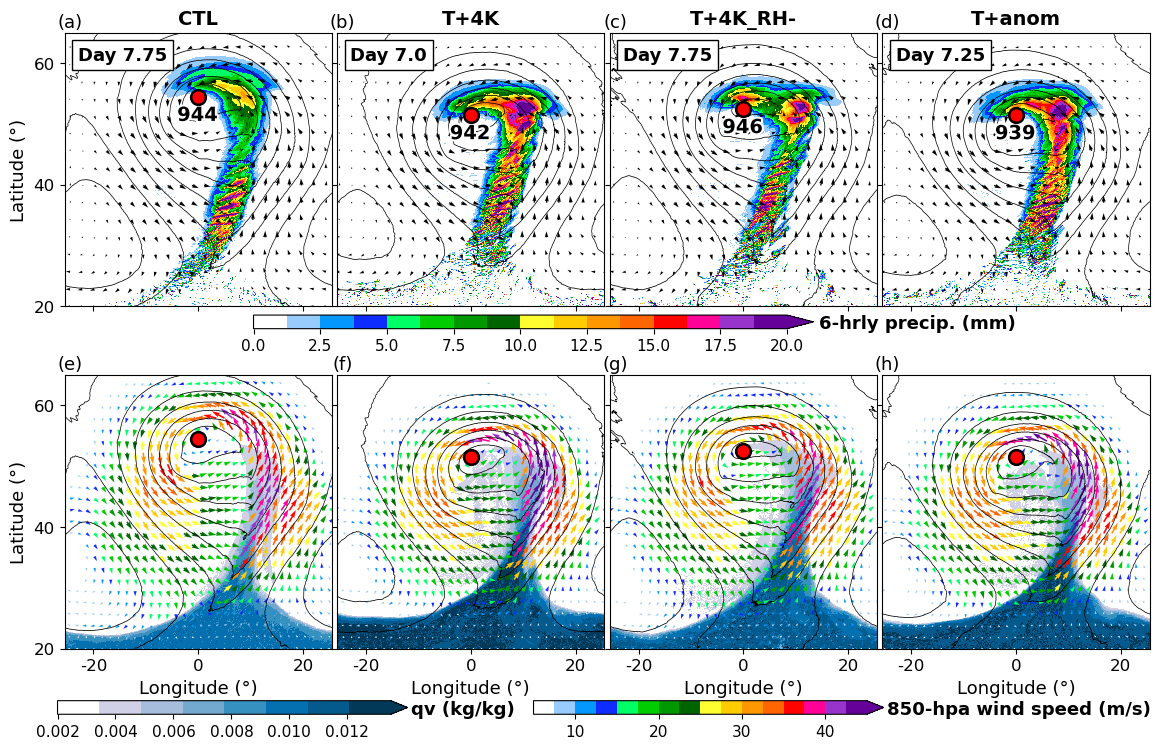

In [34]:
fig = plt.figure(figsize=(14,8)) #,layout="constrained")

# set up figure structure
nrows = 2
ncols = 4

gs = GridSpec(nrows, ncols, figure=fig)
ax = np.zeros((nrows,ncols),dtype=object)

for r in range(0,nrows):
    for c in range(0,ncols):
        ax[r,c] = plt.subplot(gs.new_subplotspec((r, c)))

# fill figure with content
for c in range(0,ncols):

    exp = experiments[c]

    # Plot mslp as contour
    # use mslp in both rows
    
    for r in range(0,nrows):
        scalefac = 0.01

        plevels=np.arange(940,1050,10)

        plot_tricontour(r,c,ds_concat[exp],'pres_msl',plevels,scalefac,lws=0.5)

    # first row: surface
    r=0
    
    # Plot 6-hourly precip as contourf
    var = 'prec_6hrly'

    vmin = 0
    #vmax = 16
    vmax = 20

    cmap = cmap_colorful

    if (r==0 and c==ncols-1):
        plot_tripcolor(r,c,
                               ds_red[exp],
                               var,
                               vmin,
                               vmax,
                               cmap,
                               cbar=True,
                               label='6-hrly precip. (mm)')
    else:
        plot_tripcolor(r,c,ds_red[exp],var,vmin,vmax,cmap)
    plot_tripcolor(r,c,ds_skewed[exp],var,vmin,vmax,cmap)
    plot_tripcolor(r,c,ds_shift[exp],var,vmin,vmax,cmap)

    # Plot 10m wind field as quiver

    # parameter to set density of arrows
    # doubling of iskip means half the number of arrows
    # is automatically scaled for both resolutions
    iskip = 3

    # parameters to set length of arrows
    scale = 700 #1000
    scale_units = 'width'
    
    # parameters to set color of arrows (if not using shading)
    color = 'k'
    alpha = 1

    if (exp in list(exp80.values())):
        plot_quiver_wind(r,c,ds_concat[exp].isel(height=0),
                         'u_10m','v_10m',
                         color=color,
                         alpha=alpha,
                        iskip=iskip,
                        scale=scale,
                        scale_units=scale_units)
    else:
        plot_quiver_wind(r,c,ds_concat[exp].isel(height=0),
                         'u_10m','v_10m',
                         color=color,
                         alpha=alpha,
                        iskip=iskip*(2**5), # factor required to obtain similar spacing
                        scale=scale,
                        scale_units=scale_units)
        
        
    # second row: 850 hPa
    r = 1
    
    # Plot qv as contourf
    var = 'qv'

    vmin = 0.2e-2
    vmax = 1.35e-2
    
    cmap = cmap_qv


    if (r==1 and c==ncols-1):
        plot_tripcolor(r,c,
                               ds_red[exp].isel(plev=0),
                               var,
                               vmin,
                               vmax,
                               cmap,
                               cbar=True,
                               label='qv (kg/kg)' )
    else:
        plot_tripcolor(r,c,ds_red[exp].isel(plev=0),var,vmin,vmax,cmap)
    plot_tripcolor(r,c,ds_skewed[exp].isel(plev=0),var,vmin,vmax,cmap)
    plot_tripcolor(r,c,ds_shift[exp].isel(plev=0),var,vmin,vmax,cmap)
    
    

    # Plot wind field as quiver

    # parameter to set density of arrows
    # doubling of iskip means half the number of arrows
    # is automatically scaled for both resolutions
    iskip = 2
    color = 'k'
    alpha = 1
    
    # parameters for shading of arrows
    cmap = cmap_colorful #'YlOrRd'
    vmin = 5
    vmax = 45

    if (exp in list(exp80.values())):
        cbar= plot_quiver_wind(r,c,
                         ds_concat[exp].isel(plev=0),
                         'u','v',
                         color=color,
                         alpha=alpha,
                        iskip=iskip,
                        scale=scale,
                        scale_units=scale_units,
                        color_var='wind_850hPa',
                         cmap=cmap,
                        vmin=vmin,
                        vmax=vmax)
    else:
        cbar= plot_quiver_wind(r,c,ds_concat[exp].isel(plev=0),
                         'u','v',
                         color=color,
                         alpha=alpha,
                        iskip=iskip*(2**5), # factor required to obtain similar spacing
                        scale=scale,
                        scale_units=scale_units,
                        color_var='wind_850hPa',
                         cmap=cmap,
                        vmin=vmin,
                        vmax=vmax)
        
for r in range(0,nrows):
    for c in range(0,ncols):
        
        exp = experiments[c]
        
        # Add marker at cyclone center
        cen_lat=track_lat[exp][t_index[exp]]
        ax[r,c].scatter(lon_min+lon_ext/2, cen_lat, c='k', s=130, zorder=20)
        ax[r,c].scatter(lon_min+lon_ext/2, cen_lat, c='r', s=60, zorder=20)

        # Set limits, ticks, and labels
        ax[r,c].set_xlim(lon_min,lon_max)

        lonticks = 20
        ax[r,c].set_xticks([lon_min+lon_ext/2-lonticks,
                            lon_min+lon_ext/2,
                            lon_min+lon_ext/2+lonticks],
                           [-lonticks,0,lonticks])
        ax[r,c].set_ylim(latmin,latmax)
        ax[r,c].set_yticks([20,40,60])

        if c==0:
            ax[r,c].set_ylabel('Latitude (°)',fontsize=13)

        else:
            ax[r,c].set_yticklabels('')
        if r==1:
            ax[r,c].set_xlabel('Longitude (°)',fontsize=13)
        else:
            ax[r,c].set_xticklabels('')
            
            xtxt = 0.05
            ytxt = 0.90

            ax[r,c].text(xtxt,
             ytxt,
                 'Day '+str(t_plot[exp]),
                 ha='left',
                 weight='bold',
                 fontsize=13,
                 bbox=dict(ec='k',
                 fc='white'),
                 transform=ax[r,c].transAxes)
            
            # Add pmin to marker
            xtxt = lon_min+lon_ext/2-4
            ytxt = cen_lat-4

            ax[r,c].text(xtxt,
                 ytxt,
                     str(int(np.round(track_pmin[exp][t_index[exp]]))),
                     ha='left',
                     weight='bold',
                     fontsize=14,
                     path_effects=[pe.withStroke(linewidth=3, foreground="white")])
            
            ax[r,c].set_title(expname[c+1],weight='bold',fontsize=14)
        
        ax[r,c].tick_params(axis='both', which='major', labelsize=12)

plt.text(0.02, 1.07, '(a)', ha='center', va='top', transform=ax[0,0].transAxes, fontsize=13) 
plt.text(0.02, 1.07, '(b)', ha='center', va='top', transform=ax[0,1].transAxes, fontsize=13)
plt.text(0.02, 1.07, '(c)', ha='center', va='top', transform=ax[0,2].transAxes, fontsize=13) 
plt.text(0.02, 1.07, '(d)', ha='center', va='top', transform=ax[0,3].transAxes, fontsize=13) 
plt.text(0.02, 1.07, '(e)', ha='center', va='top', transform=ax[1,0].transAxes, fontsize=13) 
plt.text(0.02, 1.07, '(f)', ha='center', va='top', transform=ax[1,1].transAxes, fontsize=13)
plt.text(0.02, 1.07, '(g)', ha='center', va='top', transform=ax[1,2].transAxes, fontsize=13) 
plt.text(0.02, 1.07, '(h)', ha='center', va='top', transform=ax[1,3].transAxes, fontsize=13) 
            
plt.subplots_adjust(wspace=0.02,hspace = 0.25)
 
#figpath = '/work/bb1152/Module_A/A6_CyclEx/b382037_TingChen/Task3/PTE/'
figpath = './'
plt.savefig(figpath+'FigS_Snapshots_spatial_features_max_intensity_2km.png',
                bbox_inches='tight',
                dpi=100)

In [ ]:
fig = plt.figure(figsize=(16,9)) #,layout="constrained")

# set up figure structure
nrows = 2
ncols = 4

gs = GridSpec(nrows, ncols, figure=fig)
ax = np.zeros((nrows,ncols),dtype=object)

for r in range(0,nrows):
    for c in range(0,ncols):
        ax[r,c] = plt.subplot(gs.new_subplotspec((r, c)))

# fill figure with content
for c in range(0,ncols):

    exp = experiments[c]

    # Plot mslp as contour
    # use mslp in both rows
    
    for r in range(0,nrows):
        scalefac = 0.01

        plevels=np.arange(940,1050,10)

        plot_tricontour(r,c,ds_concat[exp],'pres_msl',plevels,scalefac,lws=0.5)

    # first row: surface
    r=0
    
    # Plot 6-hourly precip as contourf
    var = 'prec_6hrly'

    vmin = 0
    vmax = 16

    cmap = cmap_colorful

    if (r==0 and c==ncols-1):
        plot_tripcolor(r,c,
                               ds_red[exp],
                               var,
                               vmin,
                               vmax,
                               cmap,
                               cbar=True,
                               label='6-hrly precip. (mm)')
    else:
        plot_tripcolor(r,c,ds_red[exp],var,vmin,vmax,cmap)
    plot_tripcolor(r,c,ds_skewed[exp],var,vmin,vmax,cmap)
    plot_tripcolor(r,c,ds_shift[exp],var,vmin,vmax,cmap)
        
        
    # second row: 850 hPa
    r = 1
    
    # Plot qv as contourf
    var = 'qv'

    vmin = 0.2e-2
    vmax = 1.35e-2
    
    cmap = cmap_qv


    if (r==1 and c==ncols-1):
        plot_tripcolor(r,c,
                               ds_red[exp].isel(plev=0),
                               var,
                               vmin,
                               vmax,
                               cmap,
                               cbar=True,
                               label='850-hPa qv (kg/kg)' )
    else:
        plot_tripcolor(r,c,ds_red[exp].isel(plev=0),var,vmin,vmax,cmap)
    plot_tripcolor(r,c,ds_skewed[exp].isel(plev=0),var,vmin,vmax,cmap)
    plot_tripcolor(r,c,ds_shift[exp].isel(plev=0),var,vmin,vmax,cmap)
    
    

    # Plot wind field as quiver

    # parameter to set density of arrows
    # doubling of iskip means half the number of arrows
    # is automatically scaled for both resolutions
    iskip = 2
    color = 'k'
    alpha = 1
    
    # parameters for shading of arrows
    cmap = cmap_colorful #'YlOrRd'
    vmin = 5
    vmax = 45

    if (exp in list(exp80.values())):
        cbar= plot_quiver_wind(r,c,
                         ds_concat[exp].isel(plev=0),
                         'u','v',
                         color=color,
                         alpha=alpha,
                        iskip=iskip,
                        scale=scale,
                        scale_units=scale_units,
                        color_var='wind_850hPa',
                         cmap=cmap,
                        vmin=vmin,
                        vmax=vmax)
    else:
        cbar= plot_quiver_wind(r,c,ds_concat[exp].isel(plev=0),
                         'u','v',
                         color=color,
                         alpha=alpha,
                        iskip=iskip*(2**5), # factor required to obtain similar spacing
                        scale=scale,
                        scale_units=scale_units,
                        color_var='wind_850hPa',
                         cmap=cmap,
                        vmin=vmin,
                        vmax=vmax)
        
for r in range(0,nrows):
    for c in range(0,ncols):
        
        exp = experiments[c]
        
        # Add marker at cyclone center
        cen_lat=track_lat[exp][t_index[exp]]
        ax[r,c].scatter(lon_min+lon_ext/2, cen_lat, c='k', s=130, zorder=20)
        ax[r,c].scatter(lon_min+lon_ext/2, cen_lat, c='r', s=60, zorder=20)

        # Set limits, ticks, and labels
        ax[r,c].set_xlim(lon_min,lon_max)

        lonticks = 20
        ax[r,c].set_xticks([lon_min+lon_ext/2-lonticks,
                            lon_min+lon_ext/2,
                            lon_min+lon_ext/2+lonticks],
                           [-lonticks,0,lonticks])
        ax[r,c].set_ylim(latmin,latmax)
        ax[r,c].set_yticks([20,30,40,50,60])

        if c==0:
            ax[r,c].set_ylabel('Latitude (°)',fontsize=13)

        else:
            ax[r,c].set_yticklabels('')
        if r==1:
            ax[r,c].set_xlabel('Longitude (°)',fontsize=13)
        else:
            ax[r,c].set_xticklabels('')
            
            xtxt = 0.05
            ytxt = 0.90

            ax[r,c].text(xtxt,
             ytxt,
                 'Day '+str(t_plot[exp]),
                 ha='left',
                 weight='bold',
                 fontsize=13,
                 bbox=dict(ec='k',
                 fc='white'),
                 transform=ax[r,c].transAxes)
            
            # Add pmin to marker
            xtxt = lon_min+lon_ext/2-4
            ytxt = cen_lat-4

            ax[r,c].text(xtxt,
                 ytxt,
                     str(int(np.round(track_pmin[exp][t_index[exp]]))),
                     ha='left',
                     weight='bold',
                     fontsize=14,
                     path_effects=[pe.withStroke(linewidth=3, foreground="white")])
            
            ax[r,c].set_title(expname[c+1],weight='bold',fontsize=14)
        
        ax[r,c].tick_params(axis='both', which='major', labelsize=12)

plt.text(0, 1.07, '(a)', ha='center', va='top', transform=ax[0,0].transAxes, fontsize=13) 
plt.text(0, 1.07, '(b)', ha='center', va='top', transform=ax[0,1].transAxes, fontsize=13)
plt.text(0, 1.07, '(c)', ha='center', va='top', transform=ax[0,2].transAxes, fontsize=13) 
plt.text(0, 1.07, '(d)', ha='center', va='top', transform=ax[0,3].transAxes, fontsize=13) 
plt.text(0, 1.07, '(e)', ha='center', va='top', transform=ax[1,0].transAxes, fontsize=13) 
plt.text(0, 1.07, '(f)', ha='center', va='top', transform=ax[1,1].transAxes, fontsize=13)
plt.text(0, 1.07, '(g)', ha='center', va='top', transform=ax[1,2].transAxes, fontsize=13) 
plt.text(0, 1.07, '(h)', ha='center', va='top', transform=ax[1,3].transAxes, fontsize=13) 
            
plt.subplots_adjust(wspace=0.02,hspace = 0.25)
 
#figpath = '/work/bb1152/Module_A/A6_CyclEx/b382037_TingChen/Task3/PTE/'
#figpath = './'
#plt.savefig(figpath+'Fig_Snapshots_spatial_features_max_intensity_80km_no10mwind.png',
#                bbox_inches='tight',
#                dpi=100)